# FAISS
Facebook AI Similarity Search (FAISS) library, which has excellent GPU implementation of "brute-force" kNN (meaning that no approximation techniques compromising the accuracy of the search).

In [45]:
import sys
import time
import re
import string

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

import torch
from transformers import BertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences

import faiss
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns


def load_chunks(filepath):
    """
    Load the chunk embeddings of the text file.
    """
    # Load dataframe.
    df = pd.read_hdf(filepath)
    
    # Get chunks and their embeddings.
    chunks = df.iloc[:,-1].values
    embeddings = df.iloc[:,:-1].values
    embeddings = np.ascontiguousarray(embeddings, dtype=np.float32) # Necessary for FAISS indexing afterwards.
    
    return chunks, embeddings


def create_gpu_index(vecs, n_gpus, method):
    """
    Create FAISS index on GPU(s).
    To create a GPU index with FAISS, one first needs to create it on CPU then copy it on GPU. 
    Note that a "flat" index means that it is brute-force, with no approximation techniques.
    """
    # Build flat CPU index.
    if method=='l2':
        cpu_index = faiss.IndexFlatL2(vecs.shape[1])  # Exact Search for L2
    elif method=='ip':
        cpu_index = faiss.IndexFlatIP(vecs.shape[1])  # Exact Search for Inner Product (also for cosine, just normalize vectors beforehand)
    else:
        print("Error: Please choose between L2 distance ('l2') or Inner Product ('ip') as brute-force method for exact search. Exiting...")
        sys.exit(0)
    
    # Convert to flat GPU index.
    co = faiss.GpuMultipleClonerOptions()  # If using multiple GPUs, enable sharding so that the dataset is divided across the GPUs rather than replicated.
    co.shard = True
    gpu_index = faiss.index_cpu_to_all_gpus(cpu_index,co=co, ngpu=n_gpus)  # Convert CPU index to GPU index.
    
    # Add vectors to GPU index.
    gpu_index.add(vecs)

    return gpu_index


def load_questions(filepath, questions_type):
    """
    """
    # Load dataframe.
    df = pd.read_csv(filepath, sep=";")

    if questions_type is None:
        # Get all questions and their associated answers.
        questions = df.Question.values
        answers = df.Answer.values
    else:
        # Get questions of given type and associated answers.
        questions = df[df['QuestionType'] == questions_type].Question.values
        answers = df[df['QuestionType'] == questions_type].Answer.values
    
    return questions, answers


def encode_sentences(model_name_or_path, cache, sentences):
    """
    Given a list of sentences and a model, get the embeddings of theses sentences
    as the average of the word embeddings of the last layer.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir=cache) # Will output all hidden_states.

    print("   Tokenizing sentences...")
    tokenized = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    lengths = [len(i) for i in tokenized]
    max_len = max(lengths) if max(lengths) <= 512 else 512

    print("   Padding/Truncating sentences to {} tokens...".format(max_len))
    padded = pad_sequences(tokenized, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # For each sentence, take the embeddings of its word from the last layer and represent that sentence by their average.
    last_hidden_states = output[0]
    sentence_embeddings = [torch.mean(embeddings[:torch.squeeze((masks == 1).nonzero(), dim=1).shape[0]], dim=0).numpy() for embeddings, masks in zip(last_hidden_states, attention_mask)]
    sentence_embeddings = np.array(sentence_embeddings)
    
    return sentence_embeddings


def remove_punctuation(text):
    """
    Remove common punctuations.
    """
    return re.sub('([.,:;!?{}()])', r'', text)


def process_text(text):
    """
    """
    # Remove punctuations.
    processed = remove_punctuation(text)
    
    # Lower text.
    processed = processed.lower()
    
    # Remove stopwords.
    processed = [w for w in processed.split() if w not in stopwords.words('english')]
    return processed


def compute_score(chunk, answer):
    """
    """
    # Get all words from answer present in the chunk.
    words = [w for w in answer if w in chunk]
    
    # Define the score as the percentage of words from answer present in the chunk.
    score = (len(words)/len(answer))*100
    return score


def create_barplot(df):
    """
    """
    # Create barplot.
    sns.set(font_scale = 1)
    plt.figure(figsize=(25,10))
    ax = sns.barplot(x="Question", y="Search_score", data=df, color="salmon", saturation=.5)

    # Tweak graph.
    ax.set(xticklabels=range(df.shape[0])) # Replace x labels by query ids.
    plt.xlabel('Query', fontsize=18)
    plt.ylabel('Search score', fontsize=18)

    # Horizontal line as avergage score.
    ax.axhline(y=df["Search_score"].mean(), ls='--', label="Mean score")
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles = handles, labels = labels)

    plt.show()
    return


def create_piechart(df, top_k):
    """
    """
    # For each question, get the id of the result chunk that had the highest search score.
    # Note that the id here is simply the order of appearance of the result chunks.
    all_count = df.Top_result_idx.value_counts().sort_index()

    # In order not to plot the counts for all x result chunks, only keep the first 'top_k'
    # and sum up the counts of the remaining as one entity.
    sum_last = all_count[top_k:].sum()

    # Get the values and the labels of the top_k results.
    values = all_count[:top_k].values.tolist()
    labels = ['result '+str(i+1) for i in range(top_k)]

    # Append the sum of the remaining results.
    values.append(sum_last)
    labels.append('results > '+ str(top_k))

    # Create a new series as the counts of the top_k and the sum for > top_k.
    new_count = pd.Series(data=values, index=labels)

    # Create pie chart.
    fig, ax = plt.subplots(figsize=(25,8))
    new_count.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, labels=None)
    ax.set_ylabel('Highest search score')
    ax.legend(loc=(0.8,0.8), labels=labels)
    plt.show()
    return


def run(model_name_or_path, embeddings_filepath, questions_filepath, questions_type=None,
        cache='/raid/antoloui/Master-thesis/Code/_cache/', method='l2', n_gpus=1, topk=10):
    """
    """
    print("\nLoad chunks and their embeddings...") 
    chunks, embeddings = load_chunks(embeddings_filepath)
    
    print("\nCreate FAISS (GPU) index...")
    index = create_gpu_index(vecs=embeddings, 
                             n_gpus=n_gpus, 
                             method=method)
    
    print("\nLoad questions...")
    questions, answers = load_questions(questions_filepath, questions_type)
    
    print("\nEncode questions...")
    quest_embeddings = encode_sentences(model_name_or_path=model_name_or_path, 
                                             cache=cache,
                                             sentences=questions)
    
    print("\nPerform evaluation...")
    # Create results dataframe.
    cols = ['Question', 'Answer', 'Search_score', 'Top_result_idx']
    additional_cols = ['result'+str(i+1) for i in range(topk)]
    cols.extend(additional_cols)
    additional_cols = ['result'+str(i+1)+'_L2dist' for i in range(topk)]
    cols.extend(additional_cols)
    df = pd.DataFrame(columns=cols)
    
    # For each question-answer pair, compute a score according to the results of FAISS search.
    for i, (Q, E, A) in enumerate(tqdm(zip(questions, quest_embeddings, answers)), total=len(questions)):
    
        # Process the answer.
        multiple_ans = A.split(';')
        processed_ans = [process_text(ans) for ans in multiple_ans]

        # Find topk chunks with FAISS search.
        result_dist, result_idx = index.search(E.reshape(1,768), k=topk)
        
        # Get these chunks and their L2 distances.
        result_chunks = [chunks[idx] for idx in result_idx[0]]
        result_distances = result_dist[0]

        # For each result chunk, compute a score. 
        # The score si defined as the percentage of words in the answer that appears in that chunk. 
        # If multiple answers are possible, the max score is taken.
        scores = []
        for k, (chunk,dist) in enumerate(zip(result_chunks,result_distances)):

            # Get the chunk and process it.
            processed_chunk = process_text(chunk)

            # Compute a score for that chunk according to each answer.
            scores_by_ans = [compute_score(processed_chunk, ans) for ans in processed_ans]

            # Take the maximum score out of the possible answers.
            chunk_score = max(scores_by_ans)

            # Append it to the scores list for topk chunks.
            scores.append(chunk_score)

        # Get the final score as the max score among all chunk results, and the associated chunk id.
        max_score = max(scores)
        top_chunk = scores.index(max(scores))
        #print("  QUESTION {}  -  SCORE: {:.2f}  -  BEST CHUNK: {}".format(i, max_score, top_chunk))
        
        # Add row to dataframe.
        new_row = [Q, A, max_score, top_chunk+1]
        new_row.extend(result_chunks)
        new_row.extend(result_distances)
        df = df.append(pd.Series(new_row, index=df.columns), ignore_index=True)
    
    print("  MEAN SCORE: {:.2f}".format(df["Search_score"].mean()))
        
    print("\nPlot results...")
    create_barplot(df)
    create_piechart(df, 3)
    
    print("\nDone.")

## NetBERT

In [46]:
run(
    model_name_or_path='/raid/antoloui/Master-thesis/Code/_models/netbert-830000/',
    embeddings_filepath='/raid/antoloui/Master-thesis/Data/QA/embeddings/netbert_embeddings.h5',
    questions_filepath='/raid/antoloui/Master-thesis/Data/QA/questions.csv', 
    questions_type='Knowledge'
)


Load chunks and their embeddings...

Create FAISS (GPU) index...

Load questions...

Encode questions...
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 70 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...

Perform evaluation...


TypeError: 'leave' is an invalid keyword argument for this function

## BERT


Load chunks and their embeddings...

Create FAISS (GPU) index...

Load questions...

Encode questions...
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 70 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...

Perform evaluation...
  QUESTION 0  -  SCORE: 100.00  -  BEST CHUNK: 1
  QUESTION 1  -  SCORE: 100.00  -  BEST CHUNK: 1
  QUESTION 2  -  SCORE: 0.00  -  BEST CHUNK: 0
  QUESTION 3  -  SCORE: 0.00  -  BEST CHUNK: 0
  QUESTION 4  -  SCORE: 50.00  -  BEST CHUNK: 2
  QUESTION 5  -  SCORE: 100.00  -  BEST CHUNK: 5
  QUESTION 6  -  SCORE: 100.00  -  BEST CHUNK: 1
  QUESTION 7  -  SCORE: 100.00  -  BEST CHUNK: 8
  QUESTION 8  -  SCORE: 100.00  -  BEST CHUNK: 0
  QUESTION 9  -  SCORE: 75.00  -  BEST CHUNK: 4
  QUESTION 10  -  SCORE: 25.00  -  BEST CHUNK: 1
  QUESTION 11  -  SCORE: 80.00  -  BEST CHUNK: 9
  QUESTION 12  -  SCORE: 66.67  -  BEST CHUNK: 2
  QUESTION 13  -  SCORE: 10

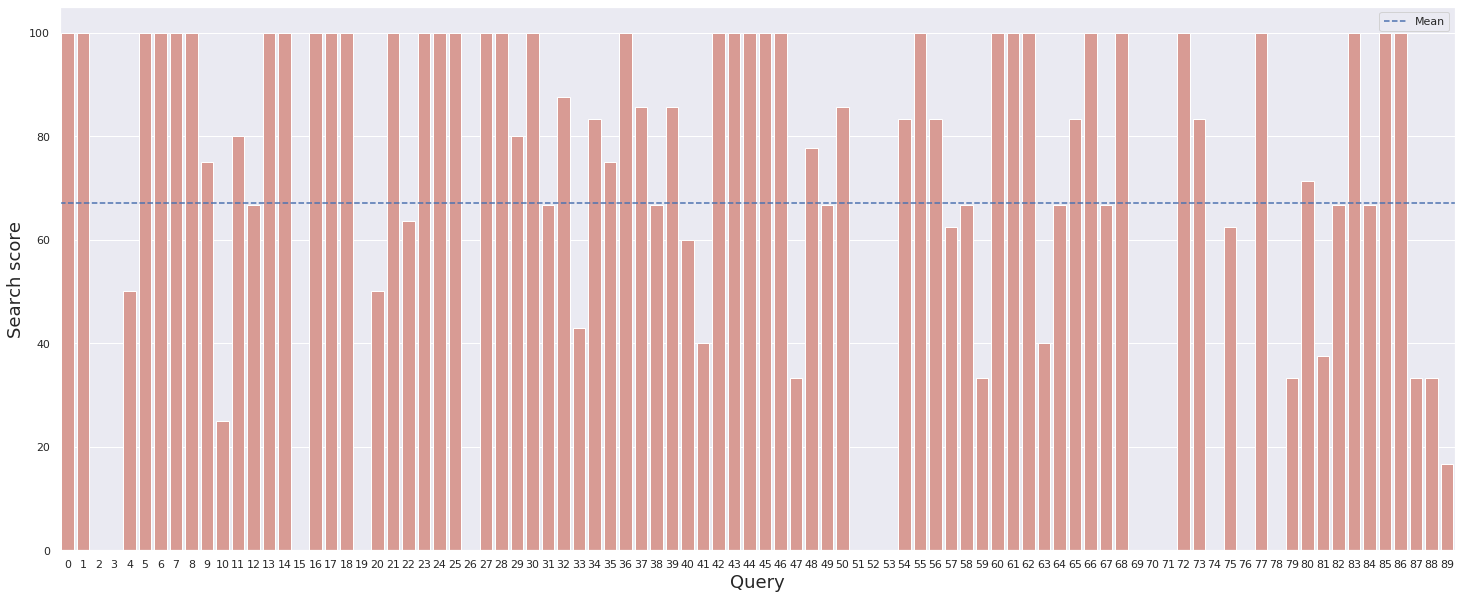


Done.


In [201]:
run(
    model_name_or_path='bert-base-cased',
    embeddings_filepath='/raid/antoloui/Master-thesis/Data/QA/embeddings/bert_embeddings.h5',
    questions_filepath='/raid/antoloui/Master-thesis/Data/QA/questions.csv',
    questions_type='Knowledge'
)